# **Train a CNN to classify images from the CIFAR-10 dataset using PyTorch**

# I. Setup



Import necessary libraries and modules.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

Set device to the first CUDA-enabled GPU if available.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# II. Data Preparation & Processing

`transform` normalizes images to a range of 0 to 1 and scales with mean and standard deviation of 0.5. `train_transform` includes additional transformations like random cropping and horizontal flipping to improve performance by providing a more diverse training dataset. Three datasets (training, validation, test) are created applying these transformations.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [3]:
# Compose a list of image transformations, including tensor conversion and normalization
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Compose a list of training image transformations with additional random crop and horizontal flip
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
        torchvision.transforms.RandomHorizontalFlip(),
    ]
)

# Load CIFAR-10 dataset for training using train_transform
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

# Load CIFAR-10 dataset for validation using basic transform (without data augmentation)
validationset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# Load CIFAR-10 dataset for testing using basic transform (without data augmentation)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

100%|██████████| 170498071/170498071 [00:04<00:00, 42588676.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# III. Create a CNN


This model is a simplified ResNet model implemented based on https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/

The model starts with two convolutional layers (`conv1` and `conv2`) followed by batch normalization and ReLU activation function. After `conv2`, there's a max pooling layer that reduces the spatial dimensions of the output.

Next, we have the first residual block (`res1`), which consists of two sub-blocks. Each sub-block has a convolutional layer followed by batch normalization and ReLU activation. The output from this residual block is added back to the input, creating a "shortcut connection" or "residual connection." This helps propagate gradients directly through the shortcut connections, mitigating the vanishing gradient problem.

Following `res1`, there are two more convolutional layers (`conv3` and `conv4`), followed by batch normalization, ReLU activation, and max pooling.

After `conv4`, we have another residual block (`res2`), similar to `res1`. The output from this block is again added back to its input via a shortcut connection.

Finally, the model has a classifier that includes a max pooling layer (to reduce spatial dimensions further), flattening operation (to convert 3D tensor into 1D tensor), and a fully connected layer (for class prediction).

The forward method defines how an input tensor flows through these layers/blocks. It takes an input tensor 'x,' passes it through each layer/block sequentially, applies the residual connections where needed, and finally returns the output from the classifier.
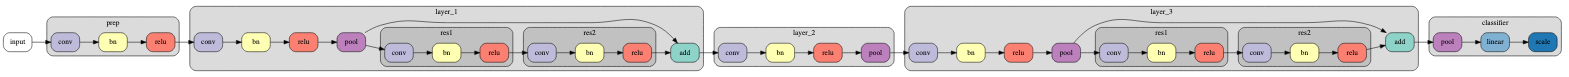

In [4]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # First residual block with two convolutional layers
        self.res1 = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            ),
        )

        # Third convolutional layer with max pooling
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # Fourth convolutional layer with max pooling
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # Second residual block with two convolutional layers
        self.res2 = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
            ),
        )

        # Final classifier with Max Pooling, Flattening, and Linear Layer
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), nn.Flatten(), nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Apply first residual block and element-wise addition
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply second residual block and element-wise addition
        x = self.res2(x) + x
        x = self.classifier(x)

        return x

Display the network structure tidily.




In [5]:
net = ResNet()
net = net.to(device)

# Batch size is for reference only. Actual batch size is determined later.
summary(net, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,792
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4          [32, 128, 32, 32]          73,856
       BatchNorm2d-5          [32, 128, 32, 32]             256
              ReLU-6          [32, 128, 32, 32]               0
         MaxPool2d-7          [32, 128, 16, 16]               0
            Conv2d-8          [32, 128, 16, 16]         147,584
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,584
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
           Conv2d-14          [32, 256,

# IV. Dataloaders



Split the training set into the `trainloader` and `validloader`. This split is made in accordance to `valid_size`, set as 20% of the total training data. Samplers for the training and validation will be computed and used later during DataLoaders creation. `NUM_WORKERS` for loading data in parallel.

In [6]:
# Set the proportion of the dataset to use for validation
valid_size = 0.2

# Get the number of training examples and create a list of indices
num_train = len(trainset)
indices = list(range(num_train))

# Calculate the index at which to split the dataset into train and validation sets
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
TRAIN_SAMPLER = SubsetRandomSampler(train_idx)
VALID_SAMPLER = SubsetRandomSampler(valid_idx)

# Set the number of workers for data loading
NUM_WORKERS = 2

def data_loaders(trainset, validationset, testset, size):
    # Create a DataLoader for training set using TRAIN_SAMPLER
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=size, sampler=TRAIN_SAMPLER, num_workers=NUM_WORKERS
    )

    # Create a DataLoader for validation set using VALID_SAMPLER
    validloader = torch.utils.data.DataLoader(
        validationset, batch_size=size, sampler=VALID_SAMPLER, num_workers=NUM_WORKERS
    )

    # Create a DataLoader for test set without using any sampler (use all examples)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=size, num_workers=NUM_WORKERS
    )

    # Return DataLoaders as a tuple (trainloader, validloader, testloader)
    return trainloader, validloader, testloader

# V. Training the network


## i. Training function
This function trains the model using CrossEntropyLoss and the Adam optimizer. It takes in a configuration dictionary, training, validation, and test sets, and an optional number of epochs. The function uses a custom `data_loaders` function to load data in batches. For each epoch, it trains the model on the training set and then evaluates it on the validation set to avoid overfitting. If the validation loss decreases, it saves the current model state. The function prints out training statistics after each epoch and returns lists of training losses and accuracies at the end.

In [7]:
def train_cifar(config, trainset, validationset, testset, epochs):
    # Instantiate the model and move it to GPU (if available)
    net = ResNet()
    net.to(device)

    # Define the loss function (Cross-entropy Loss)
    criterion = nn.CrossEntropyLoss()

    # Define the optimizer (Adam with AMSGrad)
    optimizer = optim.Adam(net.parameters(), lr=config["lr"], amsgrad=config["amsgrad"])

    # Create data loaders for train, validation and test sets
    trainloader, validloader, testloader = data_loaders(
        trainset, validationset, testset, config["batch_size"]
    )

    train_loss_list = []
    accuracy_list = []

    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    # Start training loop for given number of epochs
    for epoch in range(epochs):
        train_loss = 0.0
        net.train()

        # Train on batches from train loader
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        correct = 0
        valid_loss = 0.0
        net.eval()

        # Evaluate on batches from validation loader
        for inputs, labels in validloader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = torch.max(outputs.data, 1)[1]

                correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(TRAIN_SAMPLER)
        valid_loss = valid_loss / len(VALID_SAMPLER)
        accuracy = correct / len(VALID_SAMPLER)

        train_loss_list.append(train_loss)
        accuracy_list.append(accuracy)

        # Print current epoch's results (Training Loss, Validation Loss, and Accuracy)
        print(
            f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \t"
            f"Validation Loss: {valid_loss:.6f} \t"
            f"Validation Accuracy: {accuracy:.6f}"
        )

        # If validation loss decreased, save model and update valid_loss_min
        if valid_loss <= valid_loss_min:
            print(
                "Validation loss decreased ("
                f"{valid_loss_min:.6f} --> {valid_loss:.6f}).  "
                "Saving model ..."
            )

            torch.save(net.state_dict(), "cnn.pt")
            valid_loss_min = valid_loss
    # End of training loop
    
    print(f"\n----------- Finished Training -----------")

    
    return train_loss_list, accuracy_list

## ii. Training config
- Batch size: 16
- Number of epochs: 40
- Learning rate: 1e-4
- AMSGrad will be used

In [8]:
EPOCHS = 40

config = {"batch_size": 16, "lr": 1e-04, "amsgrad": True}

train_loss_list, accuracy_list = train_cifar(config, trainset, validationset, testset, EPOCHS)

Epoch: 0 	Training Loss: 1.214715 	Validation Loss: 0.931910 	Validation Accuracy: 0.682300
Validation loss decreased (inf --> 0.931910).  Saving model ...
Epoch: 1 	Training Loss: 0.780749 	Validation Loss: 0.608909 	Validation Accuracy: 0.791500
Validation loss decreased (0.931910 --> 0.608909).  Saving model ...
Epoch: 2 	Training Loss: 0.624095 	Validation Loss: 0.517728 	Validation Accuracy: 0.819700
Validation loss decreased (0.608909 --> 0.517728).  Saving model ...
Epoch: 3 	Training Loss: 0.533365 	Validation Loss: 0.448554 	Validation Accuracy: 0.843700
Validation loss decreased (0.517728 --> 0.448554).  Saving model ...
Epoch: 4 	Training Loss: 0.465521 	Validation Loss: 0.428890 	Validation Accuracy: 0.851300
Validation loss decreased (0.448554 --> 0.428890).  Saving model ...
Epoch: 5 	Training Loss: 0.421155 	Validation Loss: 0.420720 	Validation Accuracy: 0.854600
Validation loss decreased (0.428890 --> 0.420720).  Saving model ...
Epoch: 6 	Training Loss: 0.378545 	Vali

# VI. Evaluation

Display the training progress

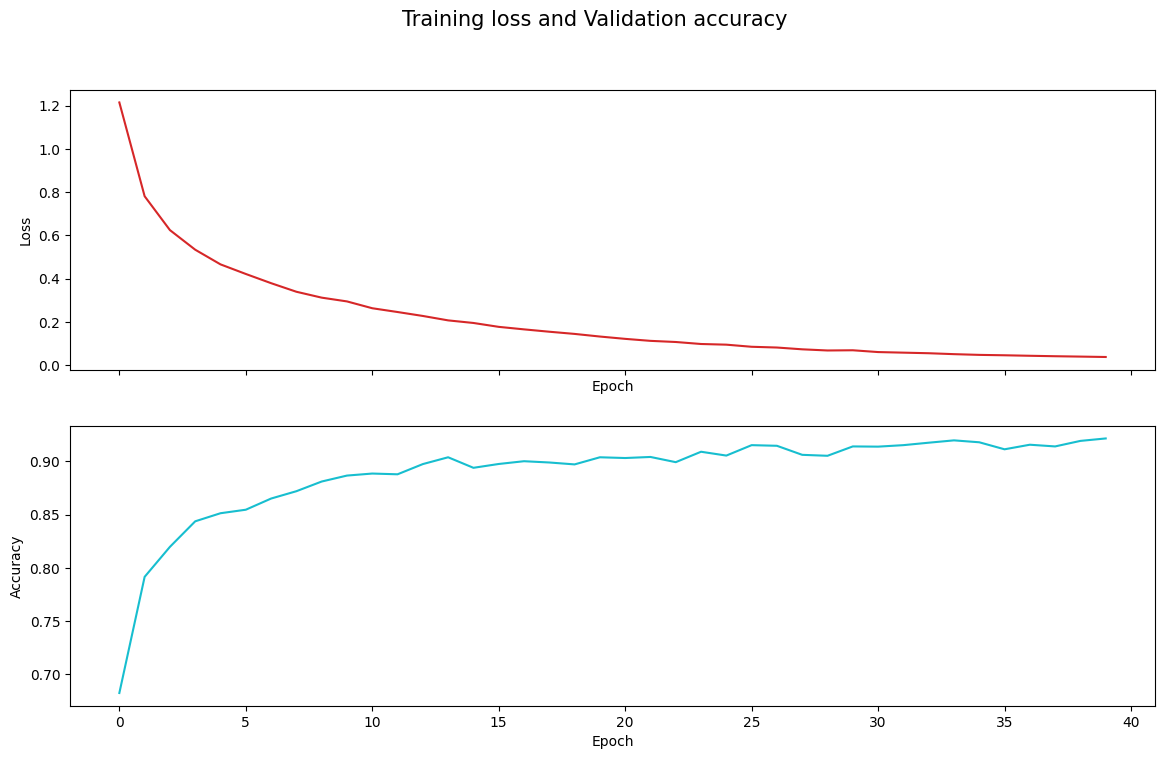

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 8), sharex=True)
fig.suptitle("Training loss and Validation accuracy", size=15)

ax1.plot([*range(EPOCHS)], train_loss_list, "tab:red", label="train loss")
ax1.set(xlabel="Epoch", ylabel="Loss")

plt.plot([*range(EPOCHS)], accuracy_list, "tab:cyan", label="accuracy")
ax2.set(xlabel="Epoch", ylabel="Accuracy")

fig.show()

- `test_accuracy(net, testloader)`: Calculates the overall accuracy of the model
- `test_accuracy_per_class(net, testloader)`: Calculates class-wise accuracy

`net.eval()` is called before testing starts to put the network into evaluation mode. Also, `torch.no_grad()` is used as a context manager to disable gradient calculations during inference which can save memory.


In [10]:
def test_accuracy(net, testloader):
    correct = 0

    # Disable gradient calculations during testing to save memory and improve performance
    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Get network predictions for test images
            outputs = net(images)

            # Find class label with highest probability for each image
            predicted = torch.max(outputs.data, 1)[1]
            
            # Compare predictions to true label
            correct += (predicted == labels).sum().item()

    return correct / len(testloader.dataset)

def test_accuracy_per_class(net, testloader):
    correct_pred = {classname: 0 for classname in trainset.classes}
    total_pred = {classname: 0 for classname in trainset.classes}

    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Get network predictions for test images
            outputs = net(images)

            # Find class label with highest probability for each image
            predicted = torch.max(outputs.data, 1)[1]

            # Compare predictions to true label
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[trainset.classes[label]] += 1
                total_pred[trainset.classes[label]] += 1

    # Calculate accuracy for each class
    accuracy_per_class = {classname: 0 for classname in trainset.classes}
    for classname, correct_count in correct_pred.items():
        accuracy = (100 * float(correct_count)) / total_pred[classname]
        accuracy_per_class[classname] = accuracy

    return accuracy_per_class

Test the accuracy of the best model (cnn.pt)

In [11]:
_, _, testloader = data_loaders(trainset, validationset, testset, config["batch_size"])

trained_net = ResNet()
trained_net.to(device)

# Load the saved best model from above
trained_net.load_state_dict(torch.load("cnn.pt"))

overall_accuracy = test_accuracy(trained_net, testloader)

print("Overall accuracy  " f"{(overall_accuracy * 100):.2f} %\n")

accuracy_per_class = test_accuracy_per_class(trained_net, testloader)

for classname, accuracy in accuracy_per_class.items():
    print(f"{classname:12s} {accuracy:.2f} %")

Overall accuracy  91.68 %

airplane     95.00 %
automobile   96.90 %
bird         89.00 %
cat          81.30 %
deer         90.40 %
dog          85.70 %
frog         95.80 %
horse        95.20 %
ship         93.30 %
truck        94.20 %
